# Introduction
### The goal of the task is to reproduce the result that the author obtained when training a model. I am working with eos74bo model and after reading the publication associated with the model, it was discovered that the author trained NCATS QSAR model (predicts aqeous solubility of small molecules) and validated it using Marketed Drugs. The model was trained with 22000 data with message-passing variant of GCNN made  available through the ChemProp22 Python package
(https://github.com/chemprop/chemprop)
### by using default parameters.

# About the dataset
### a ~2500 compound subset of thie dataset (PubChem AID: 1645848) was made publicly available and this what I downloaded and will be using for reproducing a 5 CV scheme
 

# Import necessary packages and libraries

In [42]:
# import necessary libraries
import sys
sys.path.append('/mnt/c/Users/HP/Desktop/Ersilia_ModelValidation')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import PandasTools
import chemprop
import torch
from src.src import standardise_smiles
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusio




In [49]:
# specify folder path
file_path = os.path.join('/mnt/c', 'Users', 'HP', 'Desktop', 'Ersilia_ModelValidation/AUTHOR_GCNN_MODEL')


## Data Preprocessing

In [50]:
# read the author's data into dataframe
df=pd.read_csv(os.path.join(file_path, "AID_1645848_datatable.csv"))


In [51]:
# check the size of the data
df.shape

(2534, 11)

In [52]:
# check the first 5rows
print(df.head())

  PUBCHEM_RESULT_TAG  PUBCHEM_SID  PUBCHEM_CID  \
0        RESULT_TYPE          NaN          NaN   
1       RESULT_DESCR          NaN          NaN   
2                  1  387065710.0    5280445.0   
3                  2  174007039.0      72303.0   
4                  3  144206281.0    5388936.0   

                       PUBCHEM_EXT_DATASOURCE_SMILES PUBCHEM_ACTIVITY_OUTCOME  \
0                                                NaN                      NaN   
1                                                NaN                      NaN   
2      C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O                   Active   
3           C=CCC1=CC(=C(C=C1)O)C2=CC(=C(C=C2)O)CC=C                   Active   
4  CC[C@@H]1C(=O)N2CCC[C@H]2C(=O)N([C@H](C(=O)N3C...                   Active   

   PUBCHEM_ACTIVITY_SCORE  PUBCHEM_ACTIVITY_URL  PUBCHEM_ASSAYDATA_COMMENT  \
0                     NaN                   NaN                        NaN   
1                     NaN                   NaN         

In [6]:
# the analysis column classifies the compound as soluble or not
# class 0: moderate/ high solubility
# class 1: low solubility
df['Analysis Comment'].unique()

array(['STRING',
       "Annotation/notes on a particular compound's data or its analysis as described in the published paper.",
       'class = 0', 'class = 1', nan], dtype=object)

In [7]:
# check for duplicated data
df.duplicated().sum()

0

In [8]:
# check for missing values
df.isnull().sum()

PUBCHEM_RESULT_TAG                       0
PUBCHEM_SID                              2
PUBCHEM_CID                              2
PUBCHEM_EXT_DATASOURCE_SMILES            2
PUBCHEM_ACTIVITY_OUTCOME                 2
PUBCHEM_ACTIVITY_SCORE                   2
PUBCHEM_ACTIVITY_URL                  2534
PUBCHEM_ASSAYDATA_COMMENT             2534
Phenotype                               76
Kinetic Aqueous Solubility (ug/mL)      76
Analysis Comment                        76
dtype: int64

In [9]:
# Extract the relevant columns
relevant_columns = ['PUBCHEM_EXT_DATASOURCE_SMILES', 'Analysis Comment']
df = df[relevant_columns]

# Clean formatting issues (remove leading/trailing whitespaces)
df['PUBCHEM_EXT_DATASOURCE_SMILES'] = df['PUBCHEM_EXT_DATASOURCE_SMILES'].str.strip()

# Handle missing values (drop rows with missing values)
df = df.dropna()

df = df.drop_duplicates(keep='first')

# Convert molecules to standard SMILES
df['standardized_smiles'] = df['PUBCHEM_EXT_DATASOURCE_SMILES'].apply(standardise_smiles)

# Drop the original SMILES column
df.drop(columns=['PUBCHEM_EXT_DATASOURCE_SMILES'], inplace=True)

# Map the target variable to binary values
df['outcomes'] = df['Analysis Comment'].apply(lambda x: 1 if x == 'class = 1' else 0)

# Drop the original 'Analysis Comment' column
df.drop(columns=['Analysis Comment'], inplace=True)


# Rename the column
df = df.rename(columns={'PUBCHEM_EXT_DATASOURCE_SMILES': 'smiles'})

# path to save the cleaned author's data
output_folder = r'/mnt/c/Users/HP/Desktop/Ersilia_ModelValidation/AUTHOR_GCNN_MODEL'
output_filename = 'clean_author_data.csv'
output_path = f'{output_folder}/{output_filename}'

# Save the modified DataFrame back to a CSV file
df.to_csv(output_path, index=False)



# Analyse the Data

In [4]:
df_gcnn= pd.read_csv(r"/mnt/c/Users/HP/Desktop/Ersilia_ModelValidation/AUTHOR_GCNN_MODEL/clean_author_data.csv")

In [5]:
# check the first 5 rows of cleaned data
print(df_gcnn.head())

                                 standardized_smiles  outcomes
0            O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12         0
1                C=CCc1ccc(O)c(-c2ccc(O)c(CC=C)c2)c1         0
2  CC[C@H]1NC(=O)[C@@H](NC(=O)c2ncccc2O)[C@@H](C)...         0
3     O=c1ncn2nc(Sc3ccc(F)cc3F)ccc2c1-c1c(Cl)cccc1Cl         0
4  O=C(Cc1ccc(Cl)c(Cl)c1)Nc1ccc(S(=O)(=O)Nc2ccon2...         0


In [6]:
df_gcnn.shape

(2455, 2)

In [30]:
# Map classes to solubility outcomes
df_gcnn['Solubility'] = df_gcnn['outcomes'].map({1: 'low_solubility', 0: 'high_solubility'})

### Data distribution: How many molecules do I have in each dataset? How many low solubles and how many high solubles molecules?

In [31]:
 #Count the number of molecules in each class
class_count= df_gcnn['Solubility'].value_counts()
print(class_count)

Solubility
low_solubility     1400
high_solubility    1055
Name: count, dtype: int64


### Let's visualise to understand the data

/tmp/ipykernel_3627/3534318286.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_count.index, y=class_count, palette='tab10')


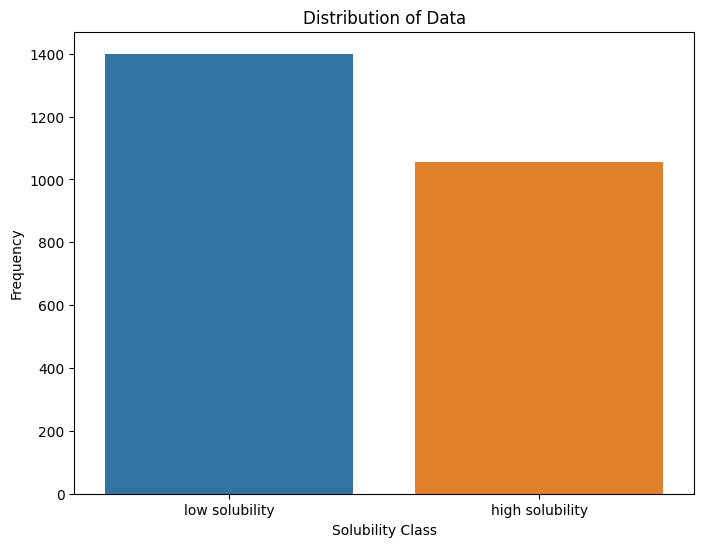

In [28]:
 #Plot a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_count.index, y=class_count, palette='tab10')
plt.title('Distribution of Data')
plt.xlabel('Solubility Class')
plt.ylabel('Frequency')
plt.show()

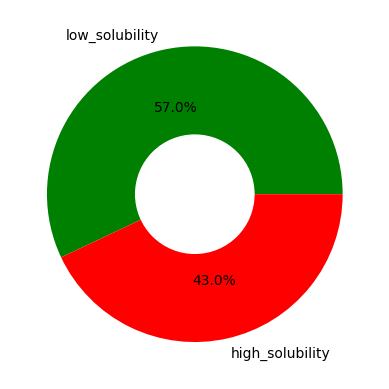

In [38]:
# use piechart to visuale the univariate categorical variable)
#create a pieplot
plt.pie(class_count.values, labels=class_count.index, colors= ['green', 'red'],autopct='%1.1f%%')


my_circle= plt.Circle((0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle);

 ### check the molecules - draw two active molecules and two inactive molecule (use the RDKIT package)

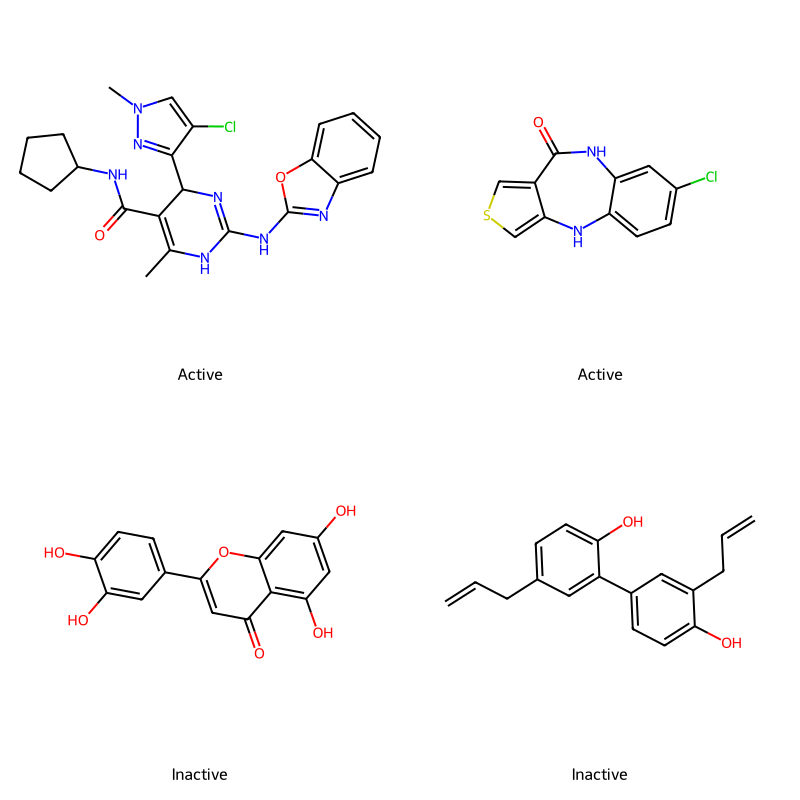

In [40]:
# Filter active and inactive molecules
active_mols =df_gcnn[df_gcnn['Solubility'] == 'low_solubility']['standardized_smiles'].head(2).apply(Chem.MolFromSmiles).tolist()
inactive_mols = df_gcnn[df_gcnn['Solubility'] == 'high_solubility']['standardized_smiles'].head(2).apply(Chem.MolFromSmiles).tolist()

# Draw the molecules
Draw.MolsToGridImage(active_mols + inactive_mols, molsPerRow=2, subImgSize=(400, 400), legends=['Active'] * 2 + ['Inactive'] * 2)

# Train classification model
The author used the graph convolutional neural network available available through the ChemProp Python package (https://
github.com/chemprop/chemprop) by using default parameters.

In [13]:
# Define paths to your preprocessed dataset and where to save model checkpoints
data_path = r"/mnt/c/Users/HP/Desktop/Ersilia_ModelValidation/AUTHOR_GCNN_MODEL/clean_author_data.csv"
checkpoint_dir = r"/mnt/c/Users/HP/Desktop/Ersilia_ModelValidation/AUTHOR_GCNN_MODEL"



In [14]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define command-line argument
arguments = [
    '--data_path', data_path,
    '--dataset_type', 'classification',
    '--save_dir', checkpoint_dir,
    '--epochs', '50',
    '--num_folds', '5',  # Perform 5-fold cross-validation
    '--save_smiles_splits',
    '--quiet'
]

# Parse arguments
args = chemprop.args.TrainArgs().parse_args(arguments)

# Run cross-validation
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

# Print mean and standard deviation of scores
print(f'Mean score: {mean_score:.4f}')
print(f'Standard deviation of score: {std_score:.4f}')


2455it [00:00, 134518.87it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 2455/2455 [00:01<00:00, 1582.20it/s]
Fold 0
0it [00:00, ?it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.
1802it [00:00, 123956.70it/s]
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:06<00:00,  6.26it/s]
                                                                                                                            
 68%|██████████████████████████████████████████████████████████▋                            | 27/40 [00:01<00:00, 20.92it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:01<00:00, 21.22it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:01<00:00, 20.24it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 16.12it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:01<00:00, 19.59it/s]
                                                                                                                            


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.92it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:01<00:00, 20.12it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:02<00:00, 19.78it/s]
                                                                                                                            
 15%|█████████████▏                                                                          | 6/40 [00:00<00:01, 19.50it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.47it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:02<00:00, 19.10it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:01<00:00, 19.24it/s]
                                                                                                                            
 65%|████████████████████████████████████████████████████████▌                              | 26/40 [00:01<00:00, 20.75it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:01<00:00, 19.60it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:02<00:00, 19.33it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 21.77it/s]
                                                                                                                            
 65%|████████████████████████████████████████████████████████▌                              | 26/40 [00:01<00:00, 14.77it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 12.14it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 17.07it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:02<00:00, 15.81it/s]
                                                                                                                            
 10%|████████▊                                                                               | 4/40 [00:00<00:02, 15.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 19.61it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.21it/s]
                                                                                                                            
 35%|██████████████████████████████▍                                                        | 14/40 [00:03<00:06,  4.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00, 12.98it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.48it/s]
                                                                                                                            
 78%|███████████████████████████████████████████████████████████████████▍                   | 31/40 [00:03<00:00, 10.54it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 10.69it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 13.70it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.55it/s]
                                                                                                                            
 15%|█████████████▏                                                                          | 6/40 [00:00<00:02, 13.51it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 13.64it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 13.24it/s]
                                                                                                                            
 20%|█████████████████▌                                                                      | 8/40 [00:00<00:02, 10.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 15.95it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 16.51it/s]
                                                                                                                            
 90%|██████████████████████████████████████████████████████████████████████████████▎        | 36/40 [00:02<00:00, 13.44it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 13.46it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.94it/s]
                                                                                                                            
 85%|█████████████████████████████████████████████████████████████████████████▉             | 34/40 [00:04<00:00,  9.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00, 13.12it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.23it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 13.21it/s]
                                                                                                                            
 20%|█████████████████▌                                                                      | 8/40 [00:00<00:02, 14.50it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 13.30it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.74it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.76it/s]


                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00, 10.45it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.79it/s]
                                                                                                                            
 40%|███████████████████████████████████▌                                                     | 2/5 [00:00<00:00, 19.62it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.77it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.66it/s]
                                                                                                                            
 50%|███████████████████████████████████████████▌                                           | 20/40 [00:01<00:01, 10.71it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 15.50it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.41it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 11.76it/s]
                                                                                                                            
  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.72it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.34it/s]
                                                                                                                            
 40%|██████████████████████████████████▊                                                    | 16/40 [00:01<00:01, 13.79it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.56it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.94it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 12.39it/s]
                                                                                                                            
 40%|███████████████████████████████████▌                                                     | 2/5 [00:00<00:00, 19.59it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  7.94it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 14.93it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:52<00:00,  3.45s/it]
Model 0 best validation auc = 0.906381 on epoch 26
Model 0 test auc = 0.858411                                                                                                 
Ensemble test auc = 0.858411
Fold 1
1394it [00:00, 3740.14it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.


1802it [00:00, 4746.67it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.21it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 10.92it/s]
                                                                                                                            
 20%|█████████████████▌                                                                      | 8/40 [00:00<00:02, 15.53it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00,  6.31it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 13.40it/s]
                                                                                                                            
 55%|███████████████████████████████████████████████▊                                       | 22/40 [00:01<00:01, 13.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.63it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.31it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 15.62it/s]
                                                                                                                            
 60%|█████████████████████████████████████████████████████▍                                   | 3/5 [00:00<00:00, 21.33it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.32it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  5.53it/s]
                                                                                                                            
  5%|████▍                                                                                   | 2/40 [00:00<00:03, 10.13it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.06it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 11.99it/s]
                                                                                                                            
 62%|██████████████████████████████████████████████████████▍                                | 25/40 [00:02<00:01, 10.47it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  8.60it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  8.77it/s]
                                                                                                                            
 70%|████████████████████████████████████████████████████████████▉                          | 28/40 [00:03<00:01, 10.50it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 12.93it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 14.23it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.39it/s]
                                                                                                                            
 15%|█████████████▏                                                                          | 6/40 [00:00<00:02, 15.40it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.32it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.68it/s]
                                                                                                                            
 75%|█████████████████████████████████████████████████████████████████▎                     | 30/40 [00:02<00:00, 12.80it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.59it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 13.65it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 13.55it/s]
                                                                                                                            
  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.64it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.89it/s]
                                                                                                                            
 40%|██████████████████████████████████▊                                                    | 16/40 [00:01<00:02, 11.55it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.93it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 11.49it/s]
                                                                                                                            
 65%|████████████████████████████████████████████████████████▌                              | 26/40 [00:02<00:00, 14.26it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 14.43it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.03it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.91it/s]
                                                                                                                            
  0%|                                                                                                | 0/40 [00:00<?, ?it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 12.09it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.87it/s]
                                                                                                                            
 45%|███████████████████████████████████████▏                                               | 18/40 [00:01<00:01, 13.38it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.42it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 13.34it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.81it/s]
                                                                                                                            
 20%|█████████████████▊                                                                       | 1/5 [00:00<00:00,  7.03it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 12.18it/s]
                                                                                                                            
 80%|█████████████████████████████████████████████████████████████████████▌                 | 32/40 [00:04<00:01,  6.54it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:05<00:00,  6.61it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 13.06it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.15it/s]
                                                                                                                            
  0%|                                                                                                | 0/40 [00:00<?, ?it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  8.87it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.21it/s]
                                                                                                                            
 25%|█████████████████████▊                                                                 | 10/40 [00:00<00:02, 11.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.85it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.85it/s]
                                                                                                                            
 85%|█████████████████████████████████████████████████████████████████████████▉             | 34/40 [00:02<00:00, 11.51it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.49it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.00it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.56it/s]
                                                                                                                            
  0%|                                                                                                | 0/40 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 13.39it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  7.23it/s]
                                                                                                                            
  8%|██████▌                                                                                 | 3/40 [00:00<00:06,  5.79it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 12.90it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.77it/s]
                                                                                                                            
 40%|██████████████████████████████████▊                                                    | 16/40 [00:01<00:01, 14.73it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.34it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 15.24it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:12<00:00,  3.86s/it]
Model 0 best validation auc = 0.851839 on epoch 27
Model 0 test auc = 0.888140                                                                                                 
Ensemble test auc = 0.888140
Fold 2
0it [00:00, ?it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.
1802it [00:00, 122084.

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.00it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.19it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.87it/s]
                                                                                                                            
 30%|██████████████████████████                                                             | 12/40 [00:00<00:01, 15.53it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.51it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.15it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.15it/s]
                                                                                                                            
 60%|█████████████████████████████████████████████████████▍                                   | 3/5 [00:00<00:00, 22.53it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 10.64it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.58it/s]
                                                                                                                            
 70%|████████████████████████████████████████████████████████████▉                          | 28/40 [00:01<00:00, 15.20it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.71it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 13.53it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.45it/s]
                                                                                                                            
 20%|█████████████████▌                                                                      | 8/40 [00:00<00:02, 11.40it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.59it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.01it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.52it/s]


                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.69it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.15it/s]
                                                                                                                            
 40%|██████████████████████████████████▊                                                    | 16/40 [00:01<00:01, 14.72it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.56it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.02it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.12it/s]
                                                                                                                            


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.91it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.66it/s]
                                                                                                                            
 50%|███████████████████████████████████████████▌                                           | 20/40 [00:01<00:01, 14.55it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.92it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.43it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.36it/s]
                                                                                                                            
  5%|████▍                                                                                   | 2/40 [00:00<00:02, 15.55it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  7.96it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.17it/s]
                                                                                                                            
 60%|████████████████████████████████████████████████████▏                                  | 24/40 [00:01<00:01, 14.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.43it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.33it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.50it/s]
                                                                                                                            
 58%|██████████████████████████████████████████████████▍                                    | 29/50 [01:33<01:07,  3.21s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.13it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.96it/s]
                                                                                                                            
 60%|████████████████████████████████████████████████████▏                                  | 24/40 [00:01<00:01, 13.95it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 16.04it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 13.02it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.06it/s]
                                                                                                                            
 10%|████████▊                                                                               | 4/40 [00:00<00:02, 13.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.08it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.12it/s]
                                                                                                                            
 60%|████████████████████████████████████████████████████▏                                  | 24/40 [00:02<00:01,  8.74it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.01it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 11.06it/s]
                                                                                                                            
 48%|█████████████████████████████████████████▎                                             | 19/40 [00:01<00:02,  9.06it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  8.11it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 11.42it/s]
                                                                                                                            
 80%|█████████████████████████████████████████████████████████████████████▌                 | 32/40 [00:03<00:00, 11.70it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.46it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.65it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.77it/s]


                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 11.17it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 11.48it/s]
                                                                                                                            
 40%|███████████████████████████████████▌                                                     | 2/5 [00:00<00:00, 17.42it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:05<00:00,  7.86it/s]
                                                                                                                            
 78%|███████████████████████████████████████████████████████████████████▍                   | 31/40 [00:03<00:00, 11.77it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 10.42it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  8.63it/s]
                                                                                                                            
 65%|████████████████████████████████████████████████████████▌                              | 26/40 [00:03<00:02,  6.25it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:05<00:00,  7.20it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 10.95it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:02<00:00,  3.65s/it]
Model 0 best validation auc = 0.877131 on epoch 29
Model 0 test auc = 0.872326                                                                                                 
Ensemble test auc = 0.872326
Fold 3
0it [00:00, ?it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.
1802it [00:00, 80229.0

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  5.73it/s]
                                                                                                                            
 65%|████████████████████████████████████████████████████████▌                              | 26/40 [00:04<00:03,  3.53it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:06<00:00,  6.46it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  7.33it/s]
                                                                                                                            
 18%|███████████████▍                                                                        | 7/40 [00:00<00:03, 10.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 10.96it/s]
                                                                                                                            
 75%|█████████████████████████████████████████████████████████████████▎                     | 30/40 [00:04<00:01,  6.80it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:06<00:00,  6.27it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.52it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.32it/s]
                                                                                                                            
 40%|███████████████████████████████████▌                                                     | 2/5 [00:00<00:00, 15.53it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.86it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 11.45it/s]
                                                                                                                            
 15%|█████████████▏                                                                          | 6/40 [00:00<00:03, 10.16it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 11.56it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 12.28it/s]
                                                                                                                            
 30%|██████████████████████████                                                             | 12/40 [00:01<00:03,  8.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 10.75it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.03it/s]
                                                                                                                            
 42%|████████████████████████████████████▉                                                  | 17/40 [00:01<00:02, 10.19it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  9.63it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  7.96it/s]
                                                                                                                            
 82%|███████████████████████████████████████████████████████████████████████▊               | 33/40 [00:02<00:00, 10.14it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 10.63it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  7.63it/s]
                                                                                                                            
 80%|█████████████████████████████████████████████████████████████████████▌                 | 32/40 [00:03<00:00,  9.41it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 10.20it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  6.47it/s]
                                                                                                                            
 62%|██████████████████████████████████████████████████████▍                                | 25/40 [00:02<00:01,  9.24it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  7.05it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  3.94it/s]
                                                                                                                            
 40%|███████████████████████████████████▌                                                     | 2/5 [00:00<00:00,  5.88it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 10.19it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 12.26it/s]
                                                                                                                            
 40%|███████████████████████████████████▌                                                     | 2/5 [00:00<00:00, 18.75it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.39it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.15it/s]
                                                                                                                            
 32%|████████████████████████████▎                                                          | 13/40 [00:01<00:02, 10.70it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 13.56it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.51it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.81it/s]
                                                                                                                            
  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 15.09it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.07it/s]
                                                                                                                            
 35%|██████████████████████████████▍                                                        | 14/40 [00:01<00:02, 11.01it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:03<00:00, 14.12it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.18it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.19it/s]
                                                                                                                            
  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.10it/s]
                                                                                                                            
 92%|████████████████████████████████████████████████████████████████████████████████▍      | 37/40 [00:06<00:00,  3.06it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:06<00:00,  3.80it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 13.92it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.46it/s]
                                                                                                                            
  5%|████▍                                                                                   | 2/40 [00:00<00:02, 14.28it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.50it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 13.58it/s]
                                                                                                                            
 55%|███████████████████████████████████████████████▊                                       | 22/40 [00:01<00:01, 14.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.99it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.65it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.49it/s]
                                                                                                                            
  0%|                                                                                                | 0/40 [00:00<?, ?it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.10it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.17it/s]
                                                                                                                            
 75%|█████████████████████████████████████████████████████████████████▎                     | 30/40 [00:02<00:00, 14.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.12it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.81it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.67it/s]
                                                                                                                            
 20%|█████████████████▌                                                                      | 8/40 [00:00<00:02, 15.10it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.43it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.29it/s]
                                                                                                                            
 90%|██████████████████████████████████████████████████████████████████████████████▎        | 36/40 [00:02<00:00, 14.10it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.17it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:26<00:00,  4.14s/it]
Model 0 best validation auc = 0.898466 on epoch 23
Model 0 test auc = 0.889439                                                                                                 
Ensemble test auc = 0.889439
Fold 4
0it [00:00, ?it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.
1802it [00:00, 102938.22it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 15.36it/s]
                                                                                                                     

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:05<00:00,  7.95it/s]
                                                                                                                            
 65%|████████████████████████████████████████████████████████▌                              | 26/40 [00:02<00:01, 10.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 10.62it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.18it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.30it/s]
                                                                                                                            
  0%|                                                                                                | 0/40 [00:00<?, ?it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  7.98it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 11.66it/s]
                                                                                                                            
 20%|█████████████████▌                                                                      | 8/40 [00:00<00:02, 11.00it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00, 11.22it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  9.08it/s]
                                                                                                                            
 35%|██████████████████████████████▍                                                        | 14/40 [00:01<00:02, 11.95it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.96it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.28it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.98it/s]


                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.96it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.51it/s]
                                                                                                                            
 40%|██████████████████████████████████▊                                                    | 16/40 [00:01<00:01, 12.13it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.29it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.96it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.22it/s]
                                                                                                                            
 36%|███████████████████████████████▎                                                       | 18/50 [01:10<01:41,  3.18s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.03it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.16it/s]
                                                                                                                            
 75%|█████████████████████████████████████████████████████████████████▎                     | 30/40 [00:01<00:00, 14.94it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.13it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 11.54it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 15.14it/s]
                                                                                                                            
 20%|█████████████████▌                                                                      | 8/40 [00:00<00:02, 14.69it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 12.91it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.37it/s]
                                                                                                                            
 90%|██████████████████████████████████████████████████████████████████████████████▎        | 36/40 [00:02<00:00, 13.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.22it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.54it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.03it/s]
                                                                                                                            
 22%|███████████████████▊                                                                    | 9/40 [00:00<00:02, 12.15it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:04<00:00,  9.05it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 14.12it/s]
                                                                                                                            
 30%|██████████████████████████                                                             | 12/40 [00:01<00:02, 11.97it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.07it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.27it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 13.37it/s]


                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.66it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00,  6.62it/s]
                                                                                                                            
 40%|██████████████████████████████████▊                                                    | 16/40 [00:01<00:01, 13.59it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.81it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.41it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 13.72it/s]
                                                                                                                            
 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:00<00:00, 19.36it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 12.58it/s]
                                                                                                                            
 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00,  8.85it/s]
                                                                                                                            
 48%|█████████████████████████████████████████▎                                             | 19/40 [00:01<00:01, 10.95it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:03<00:00, 10.98it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.74it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.06it/s]
                                                                                                                            
 86%|██████████████████████████████████████████████████████████████████████████▊            | 43/50 [02:34<00:23,  3.42s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.23it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.96it/s]
                                                                                                                            
 75%|█████████████████████████████████████████████████████████████████▎                     | 30/40 [00:02<00:00, 14.15it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.62it/s]
                                                                                                                            
 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 14.56it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.15it/s]
                                                                                                                            
 25%|█████████████████████▊                                                                 | 10/40 [00:00<00:01, 15.03it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 38/40 [00:02<00:00, 15.05it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.49it/s]
                                                                                                                            
100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:55<00:00,  3.52s/it]
Model 0 best validation auc = 0.889249 on epoch 15
Model 0 test auc = 0.838650                                                                                                 
Ensemble test auc = 0.838650
5-fold cross validation
	Seed 0 ==> test auc = 0.858411
	Seed 1 ==> test auc = 0.888140
	Seed 2 ==> test auc = 0.872326
	Seed 3 ==> test auc = 0.889439
	Seed 4 ==> test a

Mean score: 0.8694
Standard deviation of score: 0.0191


# Results achieved

In [ ]:
GCNN 0.90 0.80 0.71 0.90 0.59

In [50]:
result=pd.read_csv(r"/mnt/c/Users/HP/Desktop/Ersilia_ModelValidation/AUTHOR_GCNN_MODEL/test_scores.csv")
result

,Task,Mean auc,Standard deviation auc,Fold 0 auc,Fold 1 auc,Fold 2 auc,Fold 3 auc,Fold 4 auc
0,outcomes,0.869393,0.019119,0.858411,0.88814,0.872326,0.889439,0.83865


# Observation
### I was able to achieve a mean score of 0.8694 for auc as against the 0.90 for the author's auc result. One major factor that can affect reproducibility of model result is Data. The availability of data influence the reproducibility of machine learning models. Access to the same dataset is  crucial for reproducible results. The author has 22,209 total number of compounds present in the training dataset that produced the result I want to reproduce while 2529 total number of compounds present in the publicly available dataset that I used to train and achieve results.